In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load previously cleaned data
df = pd.read_csv('../data/processed/credit_default_engineered.csv')
X = df.drop('default', axis=1)
y = df['default']

print (X.shape, y.shape)

(30000, 30) (30000,)


# Feature pre processing

In [2]:
# feature scaling 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled array back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.1, random_state=42)

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27000, 30) (3000, 30) (27000,) (3000,)


## Baseline Model

In [3]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression 
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [4]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
# XGBoost 
from xgboost import XGBClassifier

xg = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

xg.fit(X_train, y_train)

,objective,'binary:logistic'
,use_label_encoder,None
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


# Model Evaluation

In [6]:
# Evaluating Models
from sklearn.metrics import(
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'confusion_matrix': confusion_matrix(y_test, y_pred)

    }

lr_metrics = evaluate_model(lr, X_test, y_test)
rf_metrics = evaluate_model(rf, X_test, y_test)
xg_metrics = evaluate_model(xg, X_test, y_test)

print("LR Metrics:", lr_metrics)
print("RF Metrics:", rf_metrics)
print("XGB Metrics:", xg_metrics)


LR Metrics: {'accuracy': 0.8073333333333333, 'precision': 0.6372881355932203, 'recall': 0.2852807283763278, 'f1_score': 0.3941299790356394, 'roc_auc': 0.7595868074484077, 'confusion_matrix': array([[2234,  107],
       [ 471,  188]], dtype=int64)}
RF Metrics: {'accuracy': 0.7823333333333333, 'precision': 0.5039893617021277, 'recall': 0.575113808801214, 'f1_score': 0.5372076541459957, 'roc_auc': 0.7854200927064487, 'confusion_matrix': array([[1968,  373],
       [ 280,  379]], dtype=int64)}
XGB Metrics: {'accuracy': 0.8236666666666667, 'precision': 0.6825842696629213, 'recall': 0.36874051593323215, 'f1_score': 0.47881773399014776, 'roc_auc': 0.7924913739961716, 'confusion_matrix': array([[2228,  113],
       [ 416,  243]], dtype=int64)}


## Model Selection & Development

In [16]:
# threshold tuning for XGBoost & RF
from sklearn.metrics import precision_recall_curve, f1_score

def find_best_threshold(model, X_test, y_test):
    probs = model.predict_proba(X_test)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, probs)

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    best_idx = f1_scores.argmax()

    return {
        "best_threshold": thresholds[best_idx],
        "best_f1": f1_scores[best_idx],
        "precision": precisions[best_idx],
        "recall": recalls[best_idx],
    }

print("RF:", find_best_threshold(rf, X_test, y_test))
print("XGB:", find_best_threshold(xg, X_test, y_test))

RF: {'best_threshold': 0.5573431706564606, 'best_f1': 0.5538461533462498, 'precision': 0.5616224648985959, 'recall': 0.5462822458270106}
XGB: {'best_threshold': 0.3210463, 'best_f1': 0.5541448837420946, 'precision': 0.5455882352941176, 'recall': 0.5629742033383915}


In [19]:
# Re-evaluate RF and XGBoost with new thresholds

def evaluate_with_threshold(model, X_test, y_test, threshold):
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= threshold).astype(int)

    return {
        "Recall": recall_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "F1": f1_score(y_test, preds),
        "Accuracy": accuracy_score(y_test, preds),
        "Confusion Matrix": confusion_matrix(y_test, preds)
    }

print("RF tuned:", evaluate_with_threshold(rf, X_test, y_test, 0.5573431706564606))
print("XGB tuned:", evaluate_with_threshold(xg, X_test, y_test, 0.3210463))


RF tuned: {'Recall': 0.5462822458270106, 'Precision': 0.5616224648985959, 'F1': 0.5538461538461539, 'Accuracy': 0.8066666666666666, 'Confusion Matrix': array([[2060,  281],
       [ 299,  360]], dtype=int64)}
XGB tuned: {'Recall': 0.5629742033383915, 'Precision': 0.5455882352941176, 'F1': 0.5541448842419716, 'Accuracy': 0.801, 'Confusion Matrix': array([[2032,  309],
       [ 288,  371]], dtype=int64)}


In [18]:
# Optimizing Recall @ fixed precision

def optimize_recall(model, X_test, y_test):
    probs = model.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    mask = precision >= 0.50
    return{
        
        'best_recall': recall[mask].max(),
        'best_threshold': thresholds[mask.argmax()]
    }
    
print('RF:', optimize_recall(rf, X_test, y_test))
print('XGB:', optimize_recall(xg, X_test, y_test))

RF: {'best_recall': 0.5918057663125948, 'best_threshold': 0.48951233660107724}
XGB: {'best_recall': 0.5857359635811836, 'best_threshold': 0.28225532}


## Model Insight

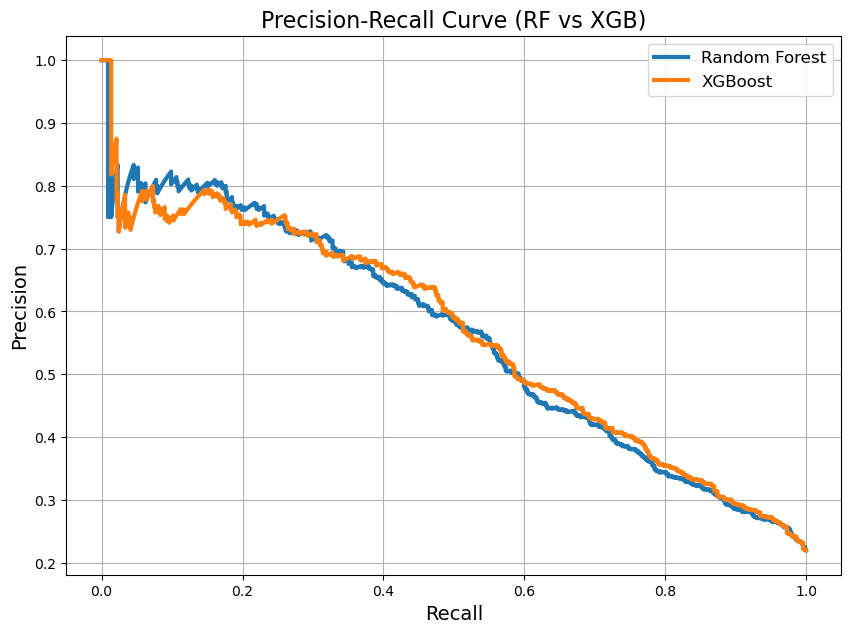

In [10]:
# compute and plot precision-recall curve for rf and xgb models
from sklearn.metrics import precision_recall_curve

# Get probabilities from both models
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = xg.predict_proba(X_test)[:, 1]

# Compute precision-recall curve
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_test, rf_probs)
xgb_precision, xgb_recall, xgb_thresholds = precision_recall_curve(y_test, xgb_probs)

# Plot precision-recall curves
plt.figure(figsize=(10, 7))

plt.plot(rf_recall, rf_precision, label='Random Forest', linewidth=3)
plt.plot(xgb_recall, xgb_precision, label='XGBoost', linewidth=3)

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve (RF vs XGB)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Model explainability

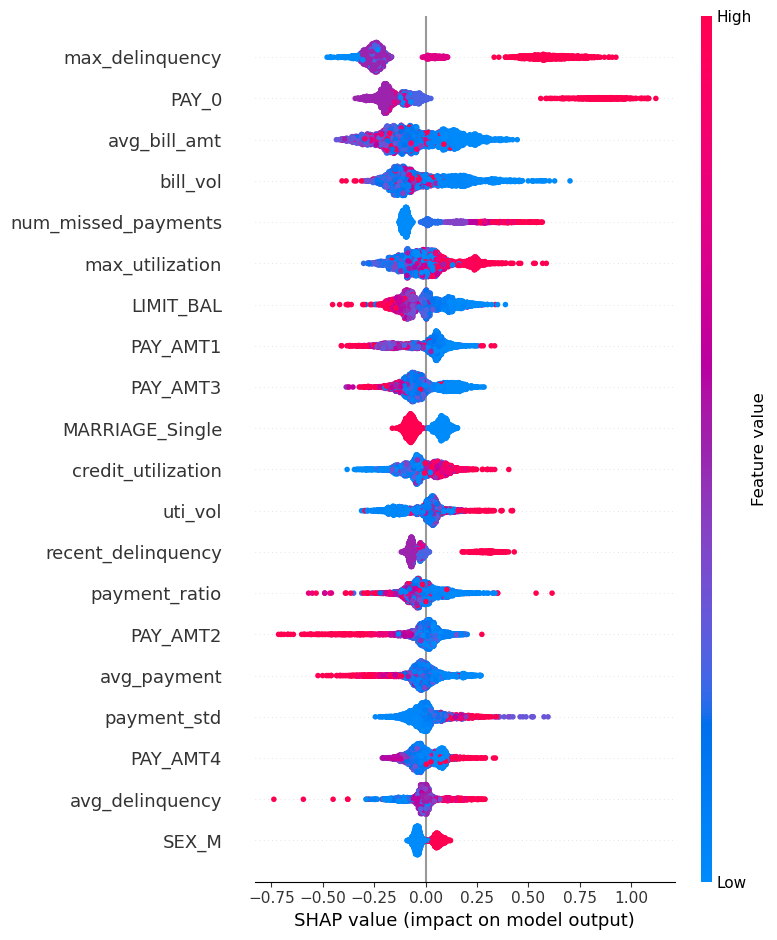

In [11]:
import shap
import numpy as np

explainer = shap.TreeExplainer(xg)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# Post-model governance 
### Model Risk accessment <br>
| Stability Ratio | Interpretation | 
| --------------- | -------------- | 
| **< 0.6**       | Stable         |
| **0.6 – 0.85**  | Medium         | 
| **> 0.85**      | Unstable       | 


In [12]:
# Stability check
explainer = shap.TreeExplainer(xg)
shap_values = explainer.shap_values(X_test)

mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
std_shap = np.std(np.abs(shap_values), axis=0)

shap_stability = pd.DataFrame({
    "feature": X_test.columns,
    "mean_abs_shap": mean_abs_shap,
    "std_abs_shap": std_shap,
    "stability_ratio": std_shap / mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

shap_stability.head(10)


,feature,mean_abs_shap,std_abs_shap,stability_ratio
17,max_delinquency,0.341398,0.182974,0.535955
1,PAY_0,0.219137,0.222869,1.017026
22,avg_bill_amt,0.144557,0.089977,0.622431
28,bill_vol,0.133171,0.087652,0.658190
19,num_missed_payments,0.123107,0.096709,0.785567
24,max_utilization,0.094545,0.079928,0.845391
0,LIMIT_BAL,0.092641,0.062642,0.676175
5,PAY_AMT1,0.088326,0.066697,0.755122
7,PAY_AMT3,0.085737,0.058074,0.677343
16,MARRIAGE_Single,0.077217,0.023389,0.302906
